#Table of contents
>[TensorFlow Time Series Forecasting Guide](#scrollTo=c3d22312)

>[Read In Pollution Dataset](#scrollTo=19cfaea6)

>[Impute Missing Dates](#scrollTo=eee312bd)

>[Split Dataset Into Train/Test](#scrollTo=1a3f9067)

>[Process Dataset with Windows](#scrollTo=d2da4469)

>[Custom Callback](#scrollTo=cdc68df2)

>[Predefined Callback - LearningRateScheduler](#scrollTo=8c93dd97)

>[Convolution Model](#scrollTo=f903798d)

>[Mixed Architecture Model](#scrollTo=93e57216)

>[Evaluate Models on Test Set](#scrollTo=f63fa932)



# TensorFlow Time Series Forecasting Guide

**In this notebook, I will demonstrate how to predict future values of univariate time series data
with models in Tensorflow.**

---------------------------------------------------------------------------------------------------


**This notebook will cover the following topics:**
- Visualizing time series data in matplotlib
- Using windows to preprocess time series data
- Creating custom callbacks
- Building LSTM based time series forecasting models
- Building Convolution-layer based time seires forecasting models
- Building mixed architecture models
- Evaluting time series forecast predictions

# Read In Pollution Dataset

The dataset we will be using comes from air quality sensors across South Korea. The sensors measure and record all types of air pollutants/particles in the air, but for this tutorial we will only look at PM<sub>2.5</sub> (fine dust).

Importing libraries

In [2]:
#Import Libraries
import tensorflow as tf
import numpy as np #Linear Algebra
import matplotlib.pyplot as plt #Data visualization
import pandas as pd #data manipulation

import warnings
warnings.filterwarnings('ignore') #Ignore warnings

#Make sure Tensorflow is version 2.0 or higher
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.15.0


The code reads pollution data from a CSV file, filters for PM2.5 values in the "Jeongnim-Dong" city, sorts the data by date, and selects a specific time range from 2018 to 2022. It then prints a sample of the time series data for the PM2.5 pollution values in the specified city.






In [3]:
#Reads in Pollution csv
pollution = pd.read_csv("data.csv",
                       parse_dates=['date'],
                       index_col='date')
#Filters for only pm25 values in Jeongnim-Dong City, sorted by date
pollution = pollution[pollution.City == 'Jeongnim-Dong'].pm25.sort_index()
#starts the dataset at 2018 and ends in 2022(due to breaks in data in previous years)
start = pd.to_datetime('2018-01-01')
end = pd.to_datetime('2022-01-01')
pollution = pollution[start:end]
print('SAMPLE OF TIME SERIES DATA:')
pollution.head()

SAMPLE OF TIME SERIES DATA:


date
2018-01-01    72
2018-01-02    95
2018-01-03    57
2018-01-04    70
2018-01-05    88
Name: pm25, dtype: int64

# Impute Missing Dates

The code checks for and imputes missing dates in the pollution time series data by creating a continuous date range from "2018-01-01" to "2022-01-01," comparing it with the existing time series dates, and filling in the missing dates with the previous value. It then sorts the data by date and sets the time index frequency as daily.






In [4]:
#Checks for and imputes missing dates
a = pd.date_range(start="2018-01-01", end="2022-01-01", freq="D") #continous dates
b = pollution.index #our time series
diff_dates = a.difference(b) # finds what in 'a' is not in 'b'

td = pd.Timedelta(1, "d") #1 day
for date in diff_dates:
    prev_val = pollution[date-td] #takes the previous value
    pollution[date] = prev_val #imputes previous value

pollution.sort_index(inplace=True)
#sets the time index frequency as daily
pollution.freq = "D"


The code creates a plot displaying the PM 2.5 values in Jeongnim-Dong City from 2018 to 2022. The x-axis represents the dates, the y-axis represents the PM 2.5 values, and the blue line connects the data points to show the trend over time.






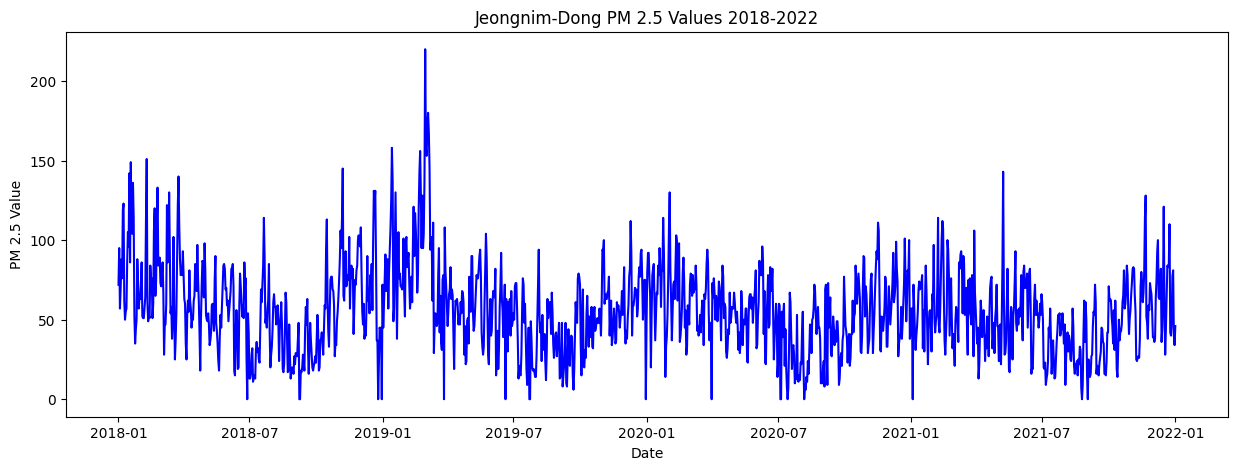

In [5]:
#displays a plot of the pm25 values since 2018
fig = plt.figure(figsize=(15,5))
plt.plot(pollution, color='blue')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Value')
plt.title('Jeongnim-Dong PM 2.5 Values 2018-2022')
plt.show()

# Split Dataset Into Train/Test

The code splits the time series data into a train set containing data from January 2018 to December 2020 and a test set containing data from January 2021 to January 2022.






In [6]:
#Split the time series data into a train and test set
end_train_ix = pd.to_datetime('2020-12-31')
train = pollution[:end_train_ix] # Jan 2018-2021
test = pollution[end_train_ix:] # Jan 2021-2022

The code visualizes the train-test split of the time series data, showing the training data in purple and the testing data in orange.






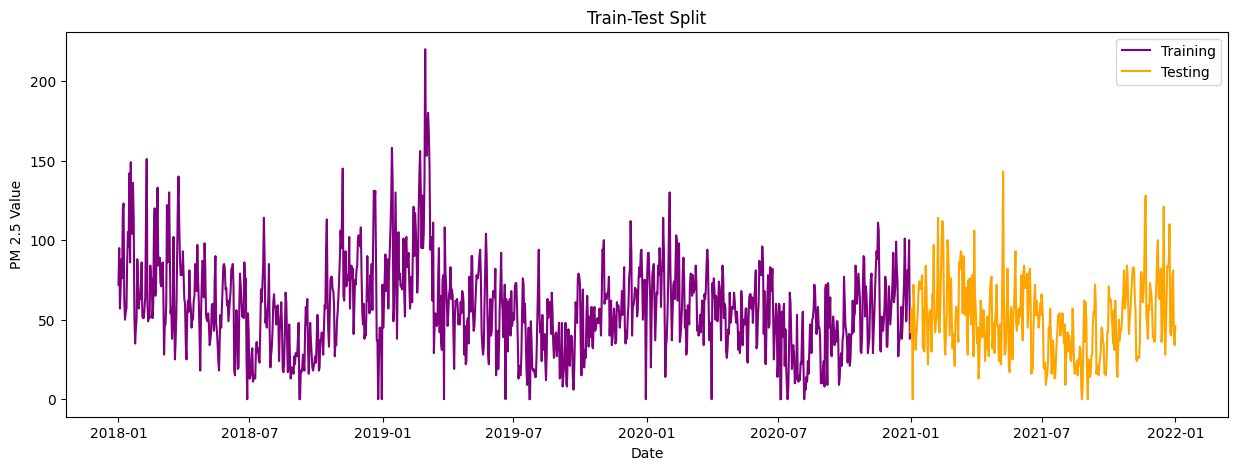

In [7]:
#displays a plot of the train/test split
fig = plt.figure(figsize=(15,5))
plt.plot(train, color='purple', label='Training')
plt.plot(test, color='orange', label='Testing')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Value')
plt.title('Train-Test Split')
plt.legend()
plt.show()

# Process Dataset with Windows

Time series data needs to be sliced into windows before being sent to a ML model. A window is essentially a limited range snapshot of our time series data. Say we have an array of values:

`[1, 2, 3, 4, 5, 6, 7, 8, 9]`

If we have a window size of 4 and we want to forecast 1 timestep in advance, this would be the result:

```
[1, 2, 3, 4] [5]
[2, 3, 4, 5] [6]
[3, 4, 5, 6] [7]
[4, 5, 6, 7] [8]
[5, 6, 7, 8] [9]
```

The code creates a windowed dataset from the time series data with a window size of 14 days. It converts the data into a TensorSliceDataset, then takes slices of the dataset with a size of the window plus one. It flattens and batches the windowed data, creating tuples of features and targets, shuffles the dataset, and finally creates batches of windows for training.






In [8]:
#Creates a windowed dataset from the time series data
WINDOW = 14 #the window value... 14 days

#converts values to TensorSliceDataset
train_data = tf.data.Dataset.from_tensor_slices(train.values)

#takes window size + 1 slices of the dataset
train_data = train_data.window(WINDOW+1, shift=1, drop_remainder=True)

#flattens windowed data by batching
train_data = train_data.flat_map(lambda x: x.batch(WINDOW+1))

#creates features and target tuple
train_data = train_data.map(lambda x: (x[:-1], x[-1]))

#shuffles dataset
train_data = train_data.shuffle(1_000)

#creates batches of windows
train_data = train_data.batch(32).prefetch(1)

The `train_data` will now have batches of windowed time series data. The batches are filled with arrays of 14 pm25 values and their target values.

# Custom Callback

Callbacks are used in Tensorflow to allow user intervention during model training. A callback can be executed at a number of specific intances during model training.
For example:
- `on_batch_begin`/`end`
- `on_epoch_begin`/`end`
- `on_predict_batch_begin`/`end`
- `on_predict_begin`/`end`
- `on_test_batch_begin`/`end`
- `on_test_begin`/`end`
- `on_train_batch_begin`/`end`
- `on_train_begin`/`end`

We will create `CustomCallback` which will stop the model from training once the model reaches under 10 mean absolute error on the training set.

Link: https://keras.io/api/callbacks/

The code defines a custom callback class called CustomCallback that inherits from Callback. It overrides the on_epoch_end method to check if the mean absolute error (mae) is less than 10.0, and if it is, it stops the training process by setting self.model.stop_training to True.






In [9]:
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') < 10.0:
            print("MAE under 10.0... Stopping training")
            self.model.stop_training = True

my_callback = CustomCallback()

# Predefined Callback - `LearningRateScheduler`

There are also a number of predefined callbacks. We will use the `LearningRateScheduler` to dynamically update the learning rate of our optimizer. This predefined callback takes a funtion that updates the learning rate as an argument.

Link: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler

The code defines a learning rate scheduler function called scheduler, which reduces the learning rate by 1% after the first two epochs. Then, it creates a LearningRateScheduler object lr_scheduler to apply this learning rate scheduling during the training process in a Keras model.






In [10]:
from tensorflow.keras.callbacks import LearningRateScheduler

#creates a function that updates the learning rate based on the epoch number
def scheduler(epoch, lr):
    if epoch < 2:
        return 0.01
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

# Convolution Model

2D Convolution layers are commonly used in computer vision tasks. Their 1D version may be used for time series data. The 1D convolutional layer tries to find patterns in different segments of the time series data.

**Pros:**
- Low parameters
- Fast training time

**Cons:**
- Tends to put more weight on recent values

The code defines a Convolutional Neural Network (CNN) model using Keras with specific layers, filters, kernel sizes, and activations. It compiles the model using Huber loss and Adam optimizer and prints a summary of the model's architecture.






In [11]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Flatten, Lambda, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam


cnn_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]),
    Conv1D(filters=32, kernel_size=3, strides=1,
           padding='causal', activation='relu'),
    Conv1D(filters=64, kernel_size=3, strides=1,
           padding='causal', activation='relu'),
    GlobalAveragePooling1D(),
    Flatten(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

cnn_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 14, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 64)            6208      
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                       

The code trains the CNN model using the provided training data for 50 epochs, applying callbacks for learning rate scheduling and custom callbacks during training, and displays the training progress.






In [12]:
#Trains CNN Model
cnn_history = cnn_model.fit(
    train_data,
    epochs=50,
    callbacks=[lr_scheduler, my_callback],
    verbose=1
)

Epoch 1/50


34/34 [==============================] - 8s 20ms/step - loss: 28.4879 - mae: 28.9846 - lr: 0.0100
Epoch 2/50
34/34 [==============================] - 0s 7ms/step - loss: 22.0034 - mae: 22.5011 - lr: 0.0100
Epoch 3/50
34/34 [==============================] - 0s 7ms/step - loss: 20.6768 - mae: 21.1719 - lr: 0.0099
Epoch 4/50
34/34 [==============================] - 0s 7ms/step - loss: 20.1976 - mae: 20.6919 - lr: 0.0098
Epoch 5/50
34/34 [==============================] - 0s 7ms/step - loss: 21.3528 - mae: 21.8493 - lr: 0.0097
Epoch 6/50
34/34 [==============================] - 0s 7ms/step - loss: 20.9336 - mae: 21.4267 - lr: 0.0096
Epoch 7/50
34/34 [==============================] - 0s 6ms/step - loss: 20.4376 - mae: 20.9332 - lr: 0.0095
Epoch 8/50
34/34 [==============================] - 0s 6ms/step - loss: 19.0024 - mae: 19.4952 - lr: 0.0094
Epoch 9/50
34/34 [==============================] - 0s 6ms/step - loss: 21.4203 - mae: 21.9145 - lr: 0.0093
Epoch 10/50
34/34 [======

The code plots the training history of the CNN model, displaying the loss and mean absolute error (MAE) over the epochs. It also prints the final loss and final MAE values after the training process.






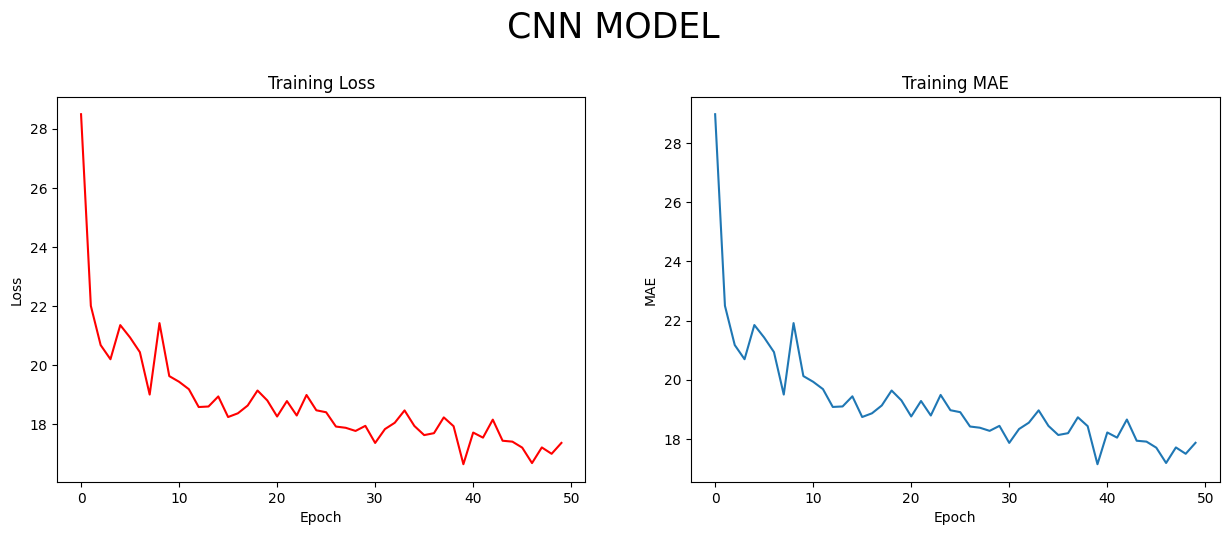

					FINAL LOSS: 17.37 | FINAL MAE: 17.86


In [13]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(cnn_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(cnn_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'CNN MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(cnn_history.history['loss'][-1], 2),
                                                 round(cnn_history.history['mae'][-1], 2)))

# Mixed Architecture Model

If we are trying to get the best of both worlds, we can mix the Convolution layers with the LSTM layers.

The code defines a mixed model with a combination of Convolutional Neural Network (CNN) and Bidirectional Long Short-Term Memory (LSTM) layers. The model has dropout layers for regularization and is compiled with the Huber loss function, Adam optimizer, and mean absolute error (MAE) metric. The summary() method displays the model architecture summary.






In [14]:
from tensorflow.keras.layers import Bidirectional, LSTM

mixed_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]),
    Conv1D(filters=64, kernel_size=3, strides=1,
           padding='causal', activation='relu'),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(1)
])


mixed_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

mixed_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 14, 1)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 14, 64)            256       
                                                                 
 bidirectional (Bidirection  (None, 14, 256)           197632    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 512)              

The code trains the mixed model using the training data train_data for 50 epochs with learning rate scheduler and custom callback functions, displaying the training progress with verbosity set to 1.






In [15]:
#Trains Mixed Model
mixed_history = mixed_model.fit(
    train_data,
    epochs=50,
    callbacks=[lr_scheduler, my_callback],
    verbose=1
)

Epoch 1/50


34/34 [==============================] - 16s 36ms/step - loss: 26.8944 - mae: 27.3902 - lr: 0.0100
Epoch 2/50
34/34 [==============================] - 1s 28ms/step - loss: 22.2611 - mae: 22.7569 - lr: 0.0100
Epoch 3/50
34/34 [==============================] - 1s 27ms/step - loss: 23.1198 - mae: 23.6125 - lr: 0.0099
Epoch 4/50
34/34 [==============================] - 1s 27ms/step - loss: 22.0496 - mae: 22.5466 - lr: 0.0098
Epoch 5/50
34/34 [==============================] - 1s 28ms/step - loss: 22.6104 - mae: 23.1069 - lr: 0.0097
Epoch 6/50
34/34 [==============================] - 1s 28ms/step - loss: 21.9964 - mae: 22.4914 - lr: 0.0096
Epoch 7/50
34/34 [==============================] - 1s 35ms/step - loss: 22.1968 - mae: 22.6916 - lr: 0.0095
Epoch 8/50
34/34 [==============================] - 1s 28ms/step - loss: 21.6901 - mae: 22.1860 - lr: 0.0094
Epoch 9/50
34/34 [==============================] - 1s 28ms/step - loss: 22.0020 - mae: 22.4981 - lr: 0.0093
Epoch 10/50
34/34 [==========

The code plots the training history of the mixed model, displaying the loss and mean absolute error (MAE) values over epochs. It also prints the final loss and MAE achieved by the model.






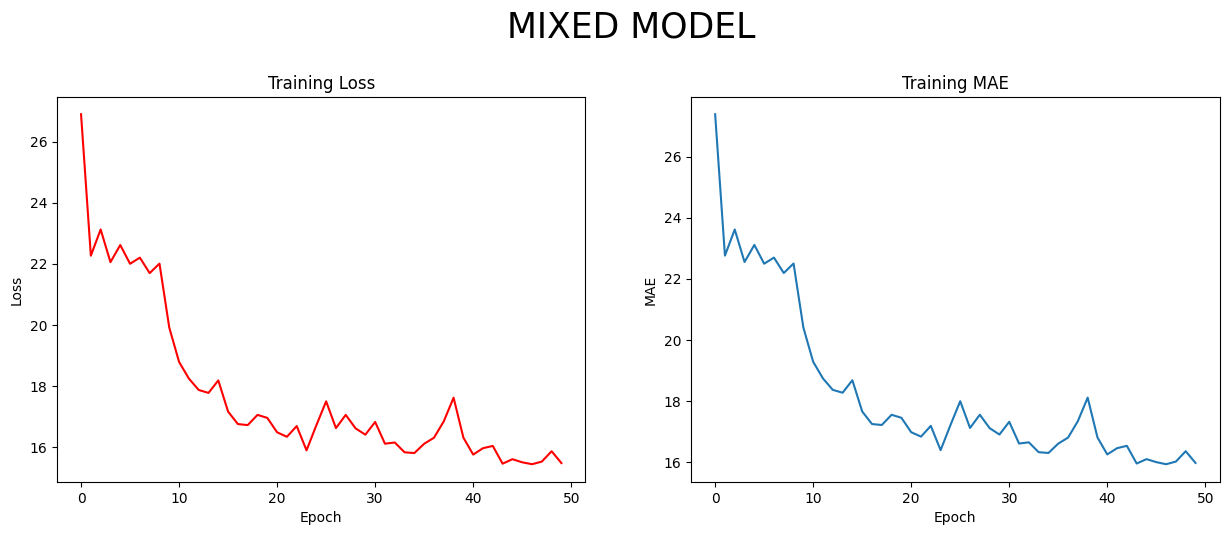

					FINAL LOSS: 15.47 | FINAL MAE: 15.96


In [16]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(mixed_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(mixed_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'MIXED MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(mixed_history.history['loss'][-1], 2),
                                                 round(mixed_history.history['mae'][-1], 2)))

# Evaluate Models on Test Set

Unlike other machine learning tasks, we cannot directly predict and evaluate the model's performance from the test data. First, we must create windows (similar to how we did on the training data) on the last 14 days of the training set and the test set. These length-14 windows will each correspond with a timestep of the test data. Predicting the next value for each of these windows will be our forecast.


*Note: Current state of the art machine learning models achieve around **13 MAE** score for this problem*


The code prepares and obtains forecasts from two models, CNN MODEL and MIXED MODEL, using sliding windows on the test dataset. The predictions are stored in the model_forecasts dictionary under their respective model names.






In [27]:
#Gets forecasts of models

all_models = [
              ('CNN MODEL', cnn_model),
              ('MIXED MODEL', mixed_model)]

model_forecasts = {
    'CNN MODEL': [],
    'MIXED MODEL': []
}

#chunck of data to be windowed so that each window associated to a value in test set
forecast_data = train[-WINDOW:]._append(test[:-1]).values

#forecast_data = pd.DataFrame(train[-WINDOW:]).append(pd.DataFrame(test[:-1])).values


for name, model in all_models:
    #converts values to TensorSliceDataset
    test_data = tf.data.Dataset.from_tensor_slices(forecast_data)
    #takes window size  slices of the dataset
    test_data = test_data.window(WINDOW, shift=1, drop_remainder=True)
    #flattens windowed data by batching
    test_data = test_data.flat_map(lambda x: x.batch(WINDOW+1))
    #creates batches of windows
    test_data = test_data.batch(32).prefetch(1)
    #gets model prediction
    preds = model.predict(test_data)
    #append to forecast dict
    model_forecasts[name].append(preds)

12/12 [==============================] - 0s 14ms/step


In [19]:
# ...

# Concatenate the train and test data into a DataFrame
forecast_data = pd.concat([train[-WINDOW:], test[:-1]], axis=0)

for name, model in all_models:
    # converts values to TensorSliceDataset
    test_data = tf.data.Dataset.from_tensor_slices(forecast_data.values)
    # takes window size slices of the dataset
    test_data = test_data.window(WINDOW, shift=1, drop_remainder=True)
    # flattens windowed data by batching
    test_data = test_data.flat_map(lambda x: x.batch(WINDOW + 1))
    # creates batches of windows
    test_data = test_data.batch(32).prefetch(1)
    # gets model prediction
    preds = model.predict(test_data)
    # append to forecast dict
    model_forecasts[name].append(preds)


12/12 [==============================] - 2s 16ms/step


The code calculates the Mean Absolute Error (MAE) scores of the forecasted values from both the CNN MODEL and MIXED MODEL by comparing them to the actual values in the test set. The MAE scores are then printed.






In [28]:
#Gets MAE score of model forecasts

N = test.values.shape[0] #number of samples in test set


cnn_mae = np.abs(test.values - model_forecasts['CNN MODEL'][0].squeeze()).sum() / N

mix_mae = np.abs(test.values - model_forecasts['MIXED MODEL'][0].squeeze()).sum() / N


print('MODEL MAE SCORES')
print('=====================================')
print('CNN MAE:', round(cnn_mae, 2))
print('MIXED MAE:', round(mix_mae, 2))

MODEL MAE SCORES
CNN MAE: 19.08
MIXED MAE: 14.62


The code displays the forecasted data along with the actual values for each model (CNN MODEL and MIXED MODEL) in three separate subplots: one for each individual model's forecast and another for the comparison of both model forecasts with the actual values.






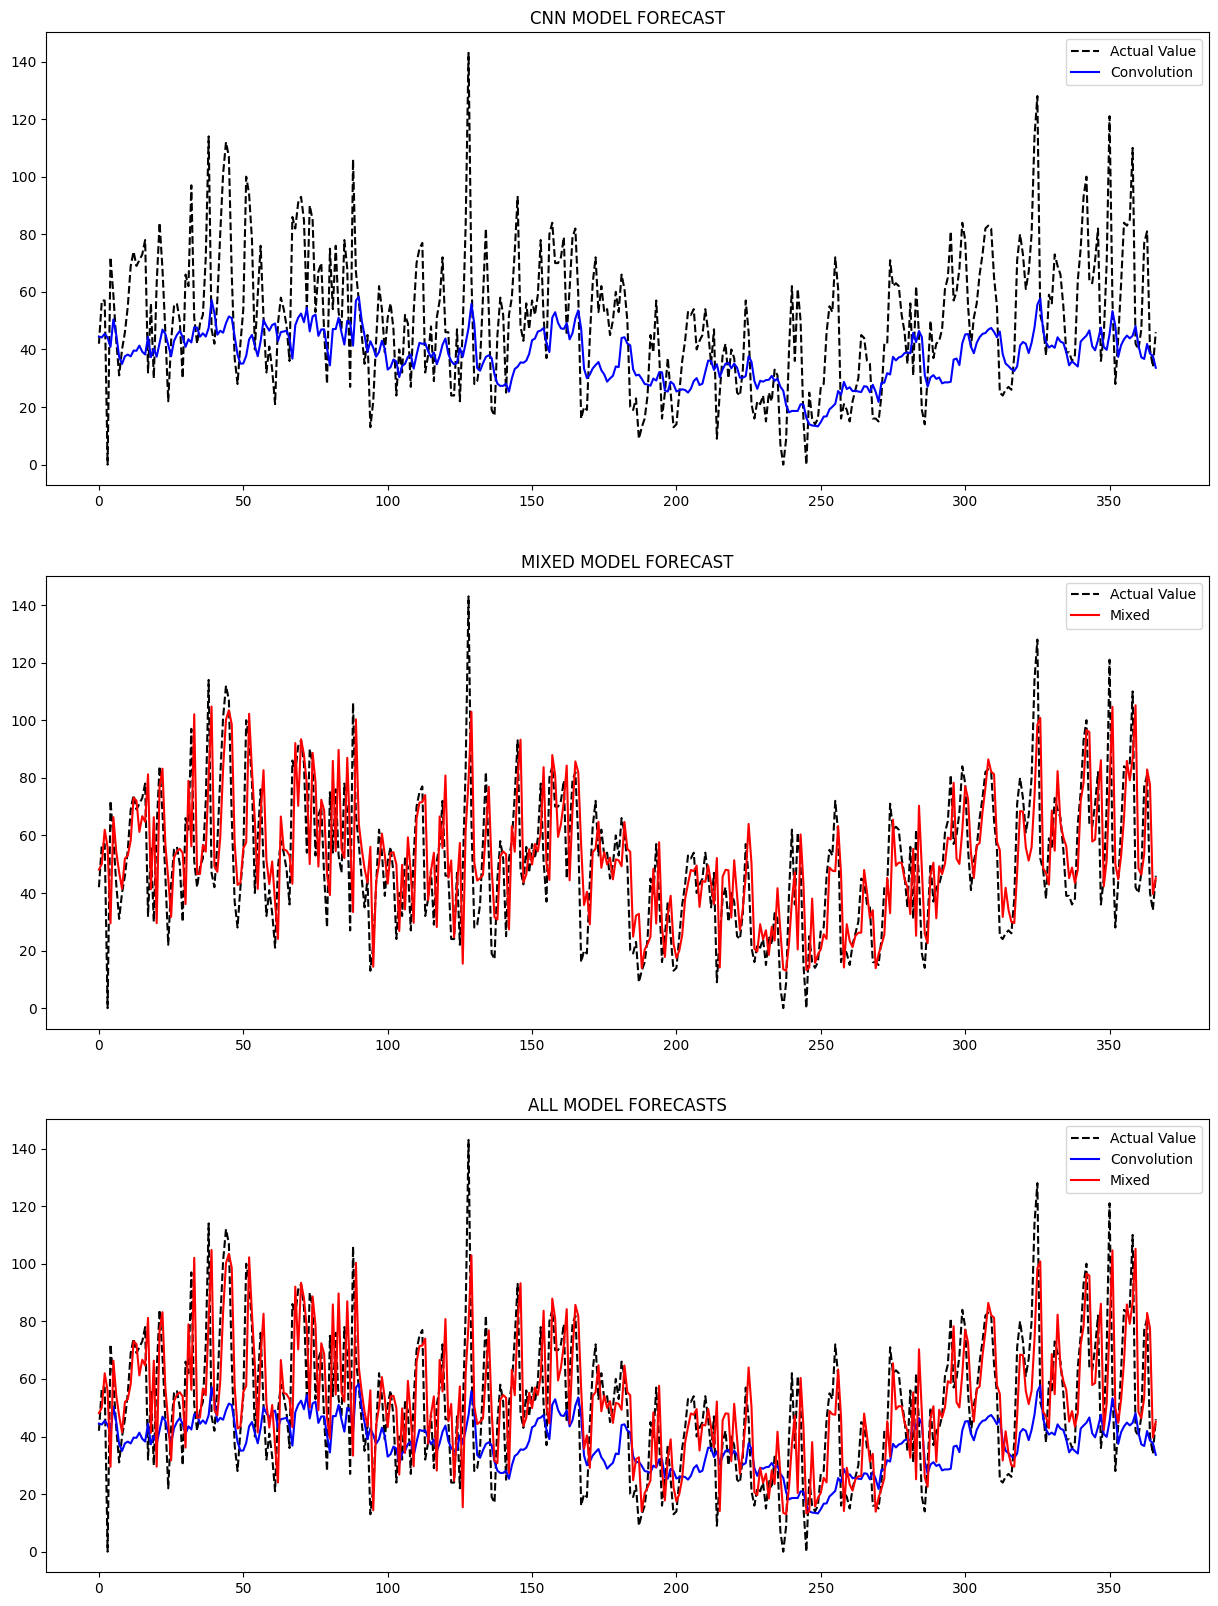

In [29]:
#displays forecasted data
plt.rcParams["figure.figsize"] = (15,20)
fig, axs = plt.subplots(3, 1)



#CNN Forcast
axs[0].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[0].plot(model_forecasts['CNN MODEL'][0].squeeze(), color='blue', label='Convolution')
axs[0].set_title('CNN MODEL FORECAST')
axs[0].legend()

#Mixed Model Forecast
axs[1].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[1].plot(model_forecasts['MIXED MODEL'][0].squeeze(), color='red', label='Mixed')
axs[1].set_title('MIXED MODEL FORECAST')
axs[1].legend()

#All forecasts
axs[2].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[2].plot(model_forecasts['CNN MODEL'][0].squeeze(), color='blue', label='Convolution')
axs[2].plot(model_forecasts['MIXED MODEL'][0].squeeze(), color='red', label='Mixed')
axs[2].set_title('ALL MODEL FORECASTS')
axs[2].legend()


plt.show()